In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

In [119]:
import matplotlib.pyplot as plt
import random
import numpy as np 
from scipy.stats import norm, multivariate_normal
from typing import Any, Dict, List

# Custom code
from src.synthetic.coordination_generator import ContinuousCoordinationGenerator
from src.synthetic.vocalics_generator import VocalicsGeneratorForContinuousCoordination
from src.transformations.series_transformations import embed_features_across_dimensions
from src.inference.vocalics import estimate_continuous_coordination

### Binary Coordination (soft coupling)

In this model, coordination is a continuous variable with value between 0 and 1. The existance of coordination affects the coupling between series $A$ and $B$, that is, to what extend $B_t$ depends on $A_{t-1}$ and vice versa. 

We start by generating synthetic data for a model with the following parameters

$
\begin{align}
C_0 &= 0 \\
p(C_t | C_{t-1}) &= \mathcal{N}(C_{t-1}, 1)\\
p(A) &= \mathcal{N}(\mu_a, I) \\
p(B) &= \mathcal{N}(\mu_b, I) \\
p(A_{t(t_a)}|C_t, B_{t(t_b-1)}) &= \mathcal{N}(f(B_{t(t_b-1)})C_t + \mu_a * (1 - C_t), I)^{C_t} \\
p(B_{t(t_b)}|C_t, A_{t(t_b-1)}) &= \mathcal{N}(f(A_{t(t_a-1)})C_t + \mu_b * (1 - C_t), I)^{C_t}
\end{align}
$

To keep coordination constrained to the range 0 and 1, we use a truncated normal for the drifting distribution and corrdination posterior. 

This model makes a series of assumptions:

1. The process starts with no coordination 
2. Coordination regulates the blending of two distributions: the series prior and the series coupling.
3. Coordination drifts over time around it's previous value
4. Samples from one series are independent of each other, that means series A and B are sampled from their priors (standard normal) if there's no coordination. 
5. We start by setting $f(.)$ to be the identity function, that means coordination is observed as a simple linear coupling betweeen the series.

First we will generate a series of coordination values over time and then we generate series A and B for two vocalic features: pitch and intensity. We assume these features are sampled independently which, in practice, allows us to work with a multivatiate normal with diagonal covariance matrix for the last 3 equations above. 

In [146]:
SEED = 0 # For reproducibility
MEAN_SHIFT = 0 # Prior series A/B mean
OBSERVATION_DENSITY = 1 # Inference is harder if density is small

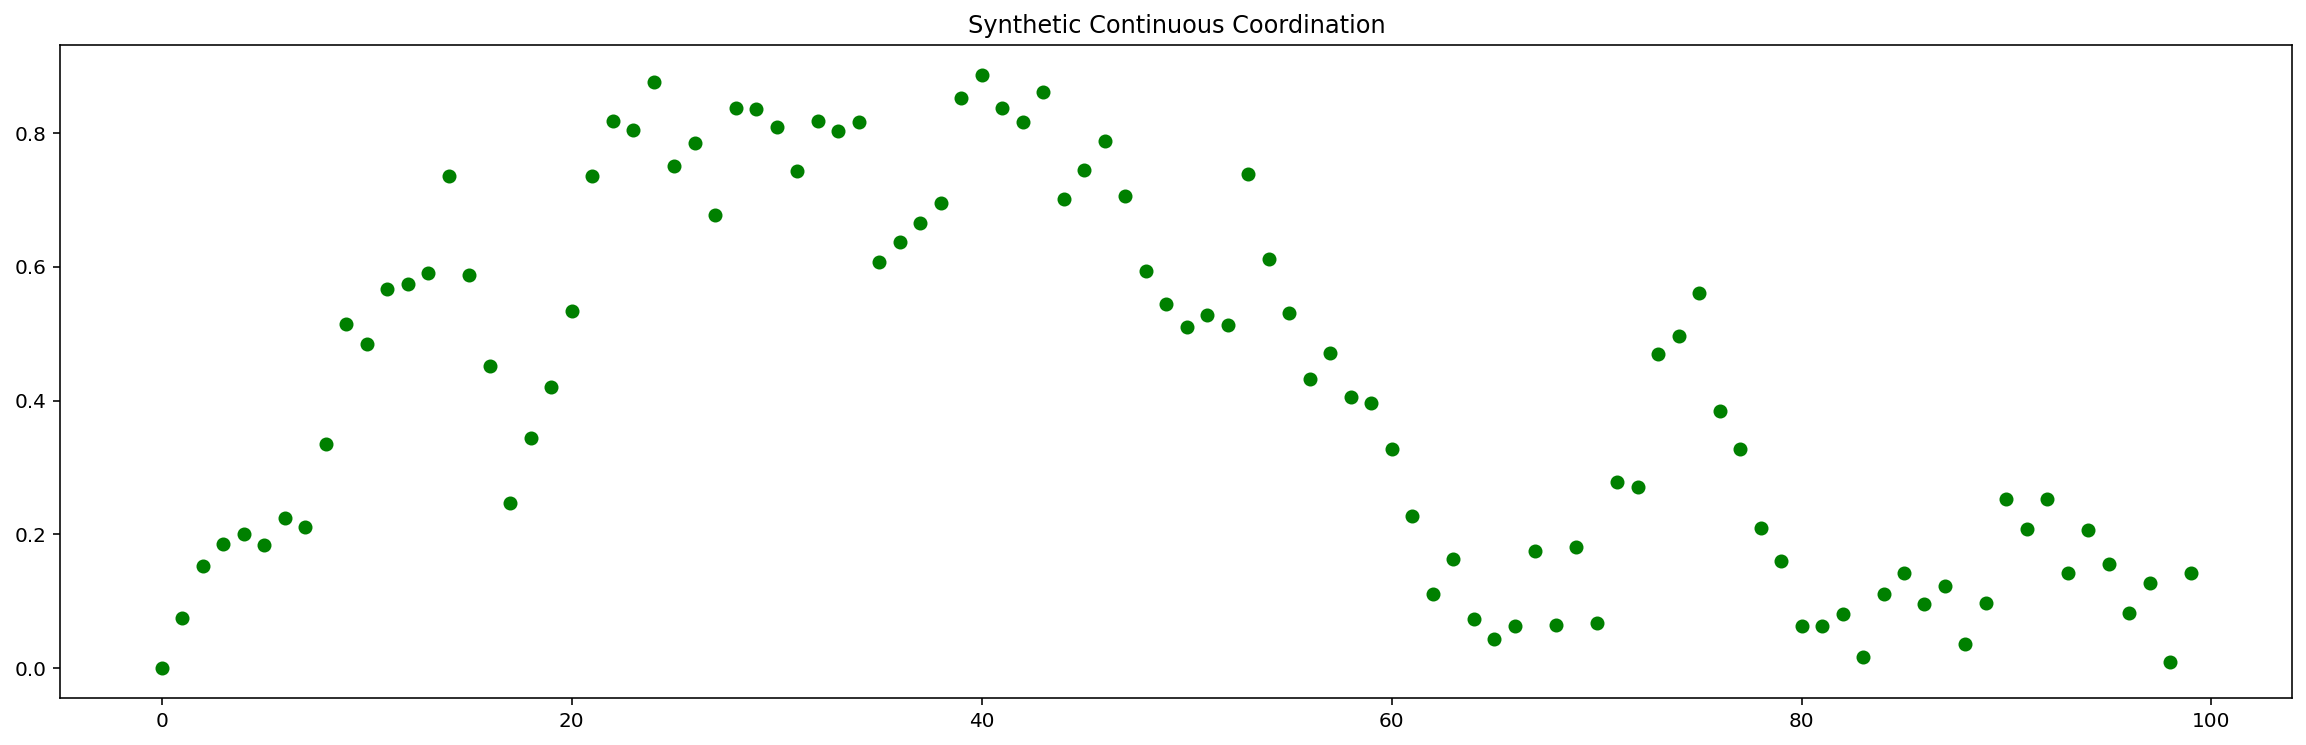

In [147]:
def plot_coordination(cs: List[float]):
    plt.figure(figsize=(20, 6))
    plt.scatter(range(len(cs)), cs, color="green")
    plt.title("Synthetic Continuous Coordination")

random.seed(SEED)
np.random.seed(SEED)
num_time_steps = 100
continuous_cs = ContinuousCoordinationGenerator().generate_evidence(num_time_steps)
plot_coordination(continuous_cs)

Text(0.5, 1.0, 'Synthetic Intensity')

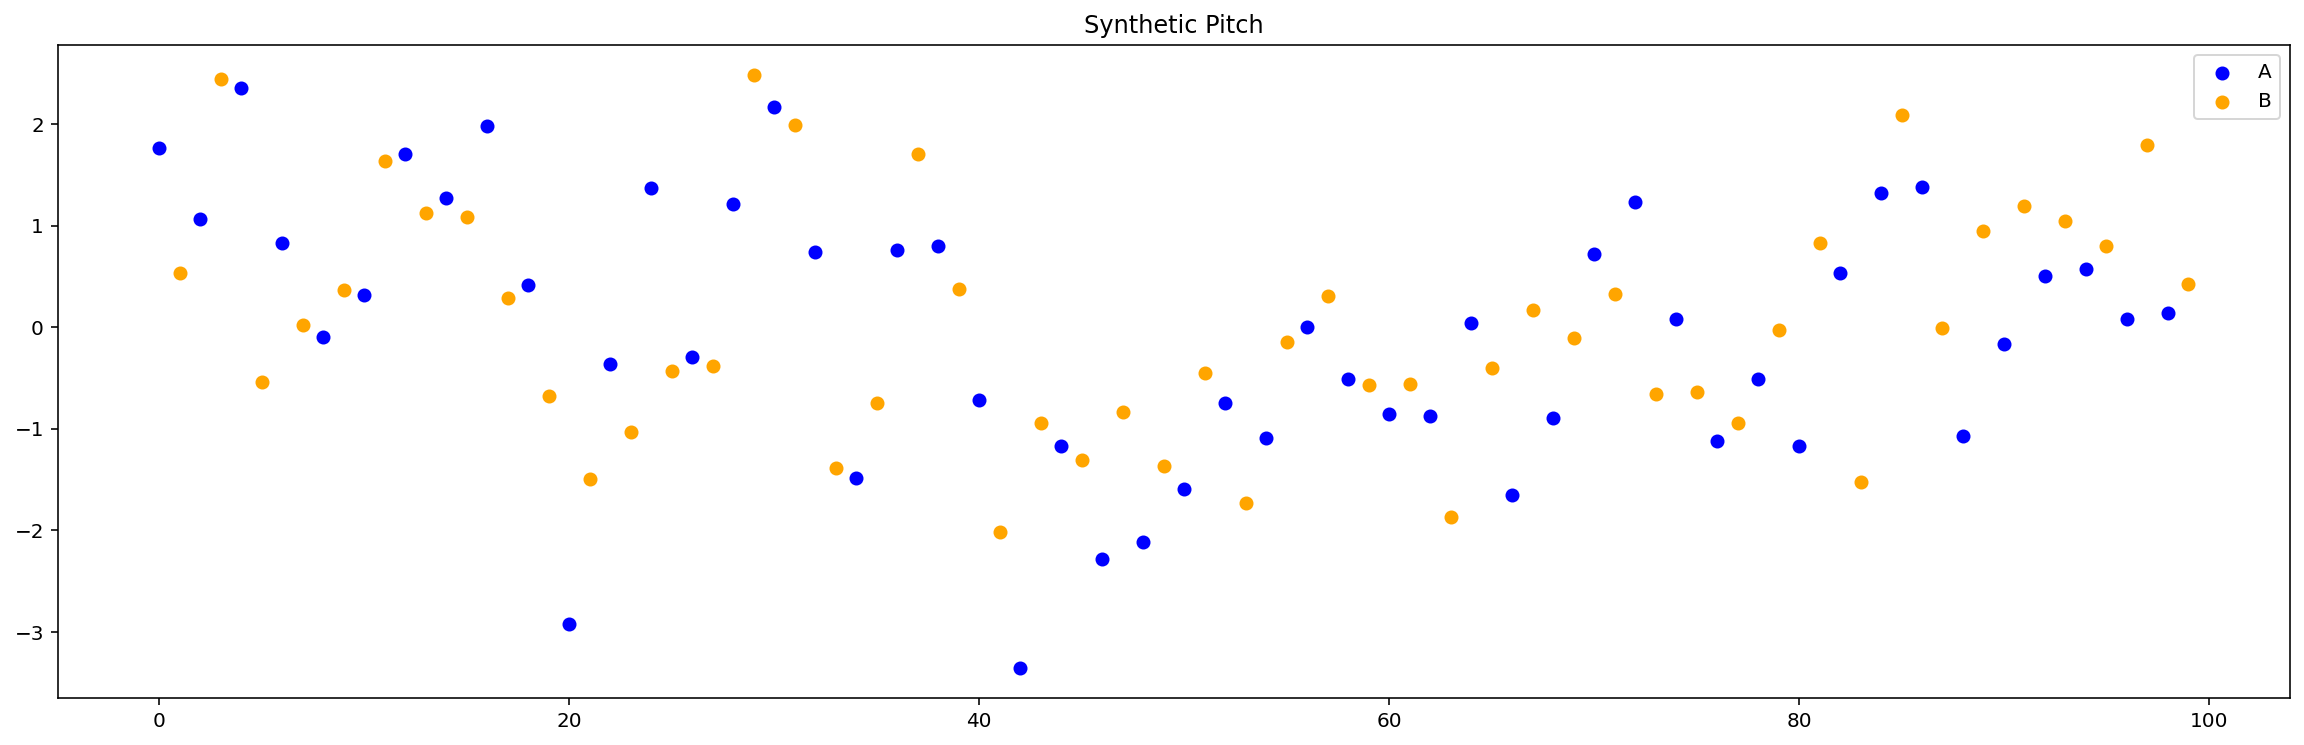

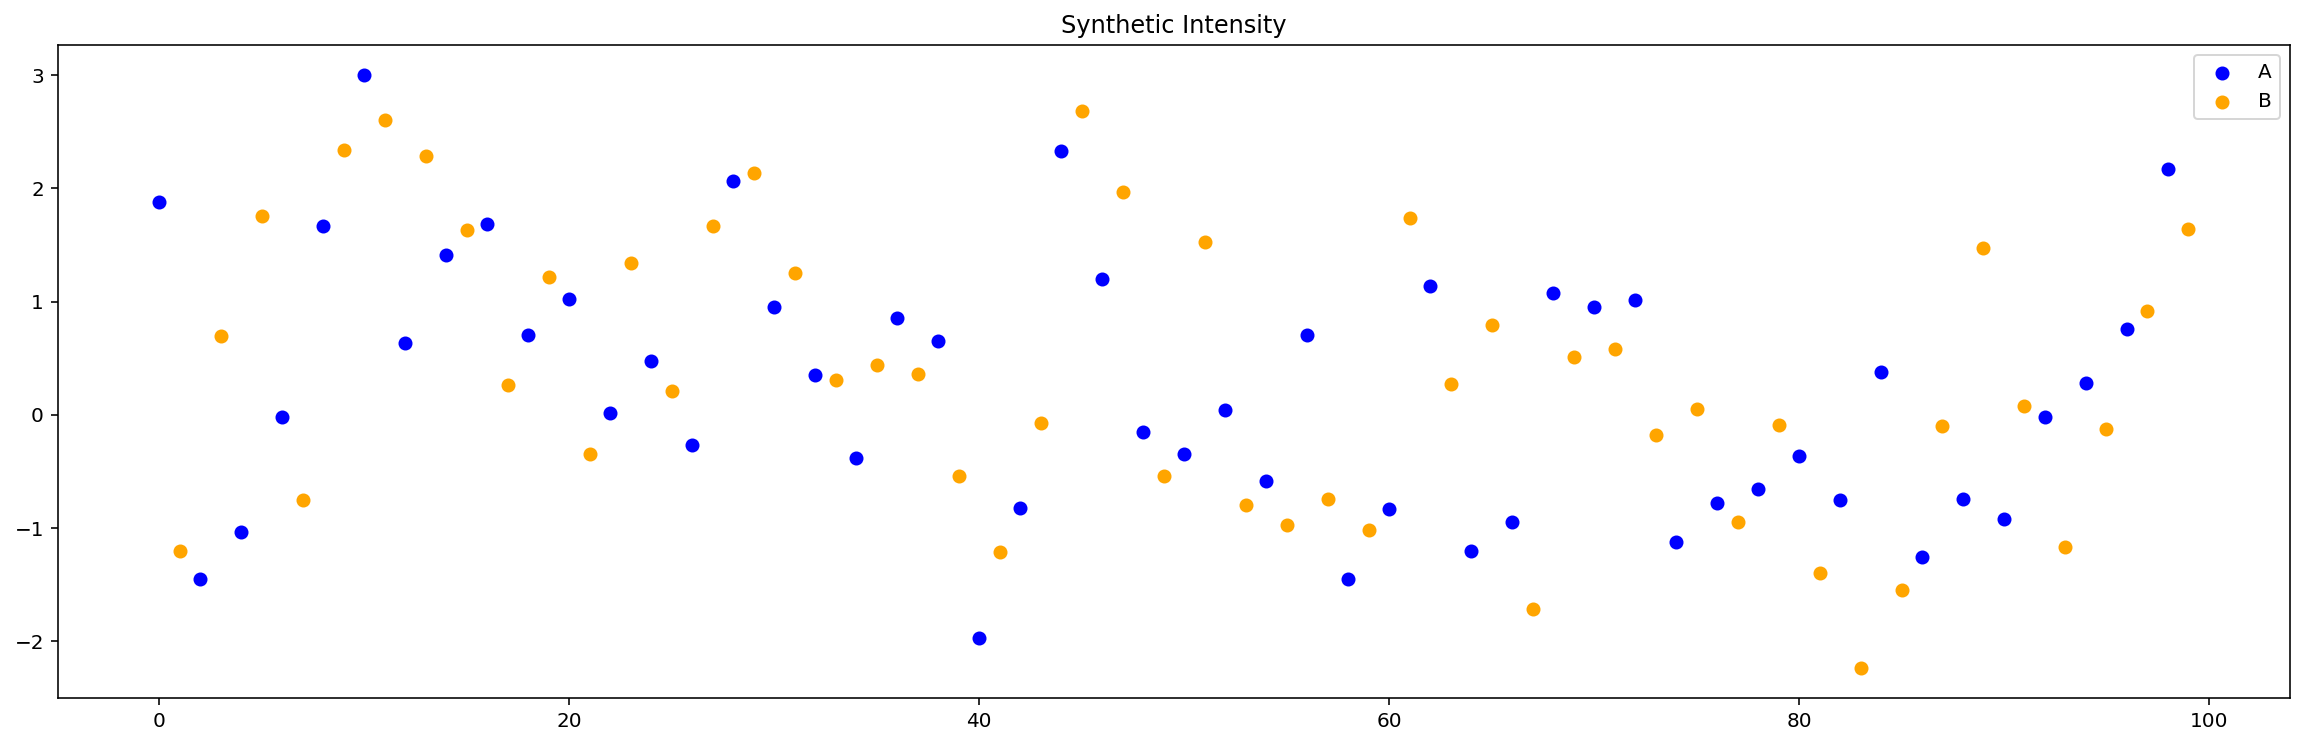

In [150]:
def plot_vocalic_series(series_a: List[float], series_b: List[float], marker: str = "o", 
                        ax: Any = None):
    if ax is None:
        plt.figure(figsize=(20, 6))
        ax = plt.gca()
    
    ax.scatter(range(len(series_a)), series_a, color="blue", label="A", marker=marker)
    ax.scatter(range(len(series_b)), series_b, color="orange", label="B", marker=marker)
    ax.legend()        
    
    return ax

random.seed(SEED)
np.random.seed(SEED)
vocalics_generator = VocalicsGeneratorForContinuousCoordination(coordination_series=continuous_cs, 
#                                                                 vocalic_features=["pitch", "intensity"], 
                                                                vocalic_features=["pitch","intensity","C","D","E","F","G","H"],
                                                                time_scale_density=OBSERVATION_DENSITY,
                                                                mean_shift_coupled=MEAN_SHIFT,
                                                                var_coupled=1)
series_a, series_b = vocalics_generator.generate_evidence()
ax_pitch = plot_vocalic_series(series_a["pitch"], series_b["pitch"])
ax_pitch.set_title("Synthetic Pitch")
ax_pitch = plot_vocalic_series(series_a["intensity"], series_b["intensity"])
ax_pitch.set_title("Synthetic Intensity")

### Inference

Based on the observed vocalic series component, we can infer the coordination at each time step. The joint distribution of coordination and vocalics components is

$
\begin{align}
p(C_{0:T}, A_{0,T_a}, B_{0,T_b}) = p(C_0)\prod^{T}_{t=1}p(C_t|C_{t-1})p(A_t|C_t, B_{t-1})p(B_t|C_t, A_{t-1})
\end{align}
$

We can not perform exact inference but we can compute the posterior of $C_t$ in a closed form. It is a truncated normal distribution with mean and standard deviation given by

Notice that the terms that depend on $A$ and $B$ might not be present for a given $t$ depending on the abcense of observations of vocalic features at that time step. This reduces the mean to a dependency only on previous and next coordination samples.

$
\begin{align}
\hat{\sigma} &= \frac{1}{2 + (\mu_a - B_{t-1})^2 + (\mu_b - A_{t-1})^2}\\
\hat{\mu} &= ((\mu_a - B_{t-1})(\mu_a - A_t) + (\mu_b - A_{t-1})(\mu_b - B_t) + C_{t-1} + C_{t+1})\hat{\sigma}
\end{align}
$

In the first time step, we have

$
\begin{align}
\hat{\sigma} &= 1\\
\hat{\mu} &= C_{t+1}
\end{align}
$

In the last time step, we have

$
\begin{align}
\hat{\sigma} &= \frac{1}{1 + (\mu_a - B_{t-1})^2 + (\mu_b - A_{t-1})^2}\\
\hat{\mu} &= ((\mu_a - B_{t-1})(\mu_a - A_t) + (\mu_b - A_{t-1})(\mu_b - B_t) + C_{t-1})\hat{\sigma}
\end{align}
$




In [155]:
multi_dim_a, mask_a = embed_features_across_dimensions(num_time_steps, series_a)
multi_dim_b, mask_b = embed_features_across_dimensions(num_time_steps, series_b)
samples = estimate_continuous_coordination(10000, multi_dim_a, multi_dim_b, 0, 0, mask_a, mask_b, MEAN_SHIFT)

100%|██████████| 10000/10000 [01:29<00:00, 111.79it/s]


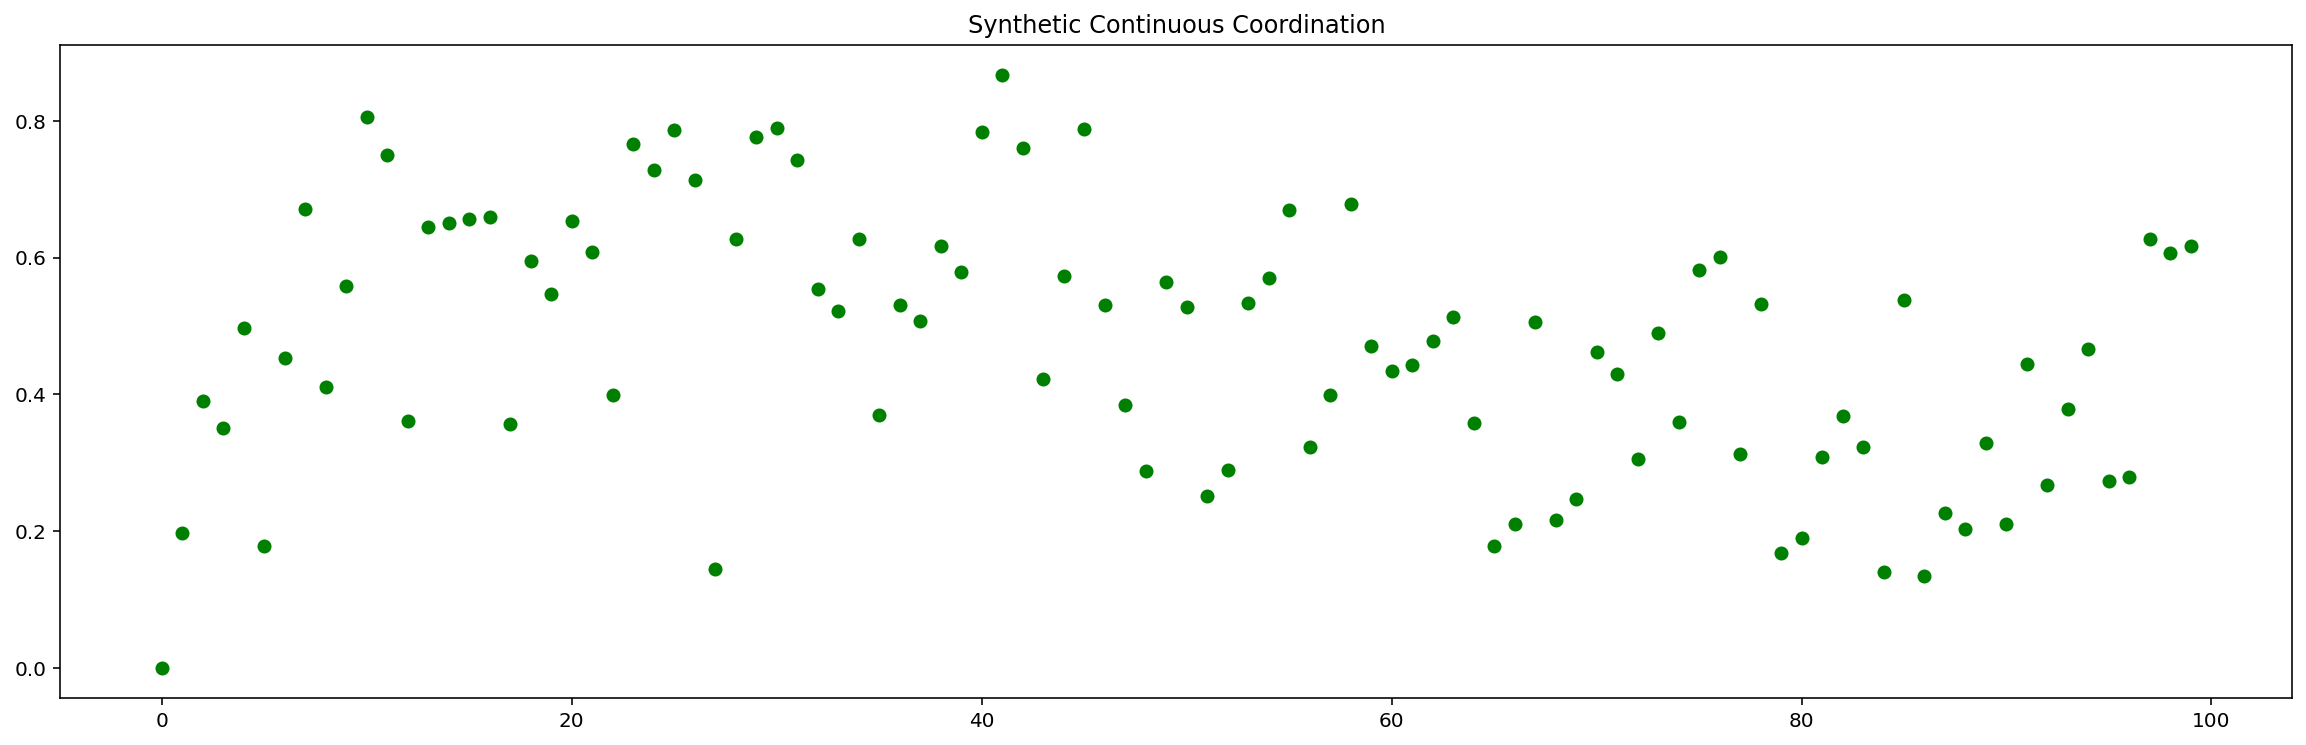

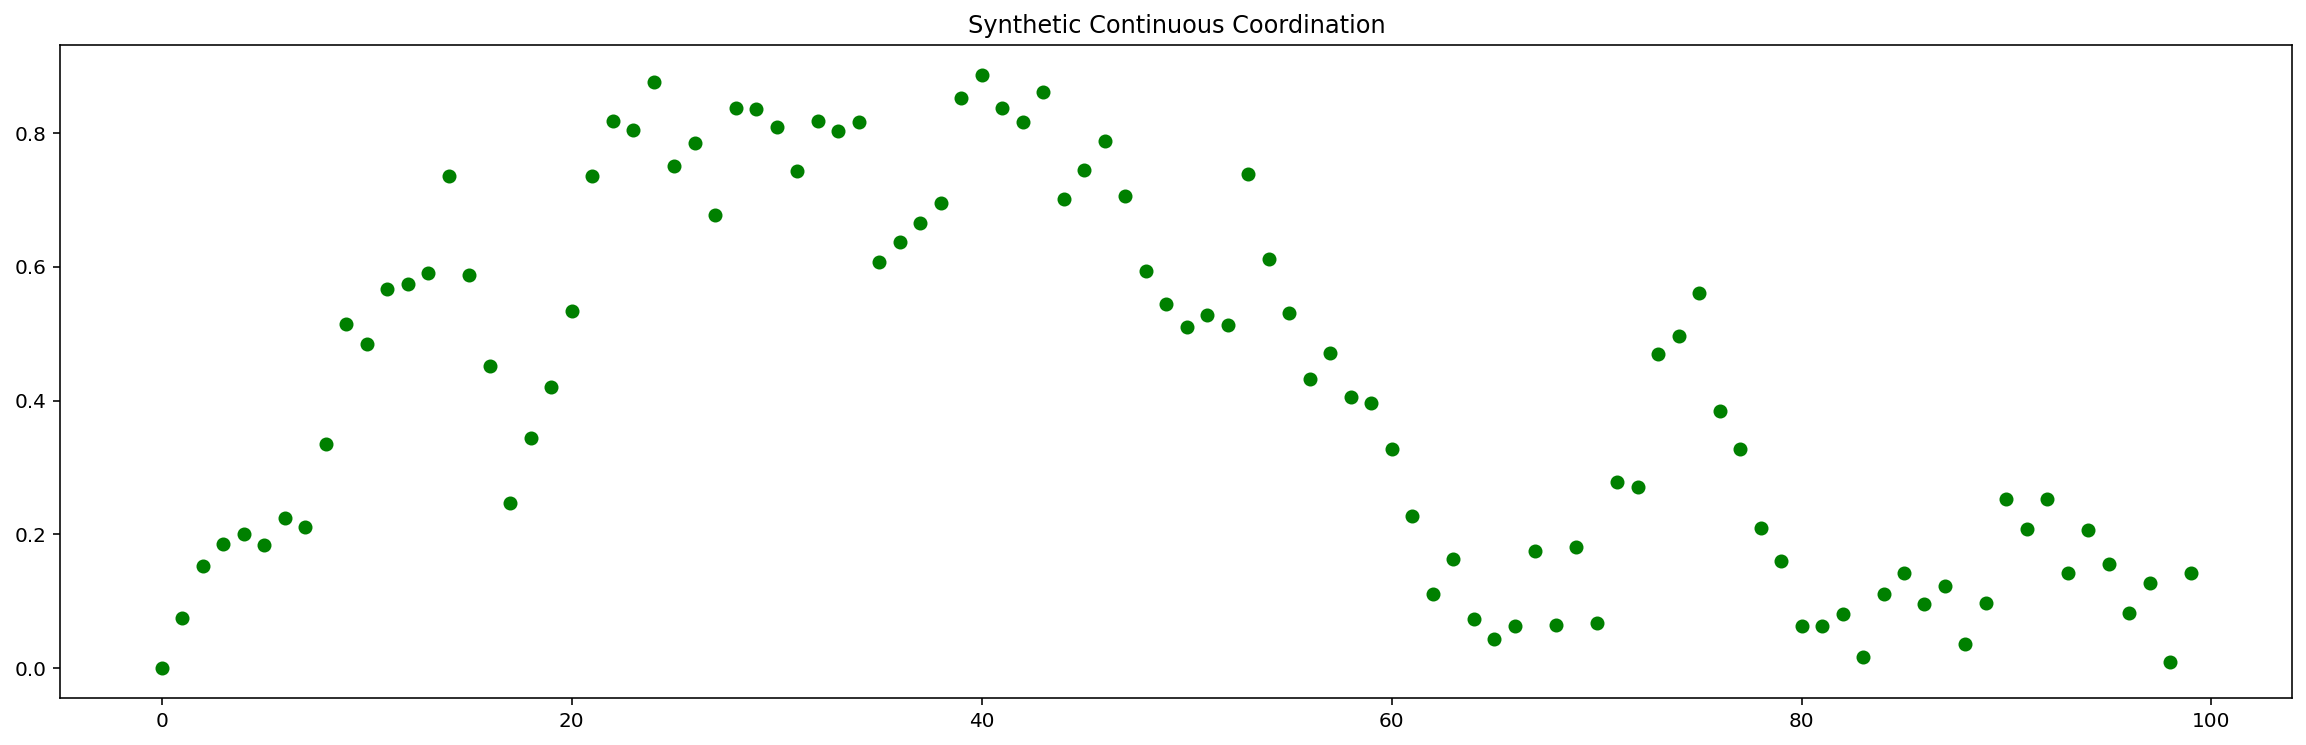

In [156]:
plot_coordination(np.mean(samples[-500:, :], axis=0))
plot_coordination(continuous_cs)